In [1]:
# Import libraries needed for the analysis
import os
import numpy as np
import pandas as pd
import random
from datetime import datetime
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


In [2]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 5
from numpy.random import seed
seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Read the training and test files

In [3]:
# read the training and test data sets (source: Kaggle)
mnist_train = pd.read_csv('./digit-recognizer/train.csv')
mnist_test = pd.read_csv('./digit-recognizer/test.csv')

# check the pandas DataFrame object - MNIST train dataset
print('\nMNIST train DataFrame:')
print(mnist_train.info())

# check the pandas DataFrame object - MNIST train dataset
print('\nMNIST test DataFrame:')
print(mnist_test.info())


MNIST train DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None

MNIST test DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


In [4]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
mnist_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis

In [6]:
#check for missing data - training data 
np.sum(mnist_train.isna().sum())

0

In [7]:
#check for missing data - test data 
np.sum(mnist_test.isna().sum())

0

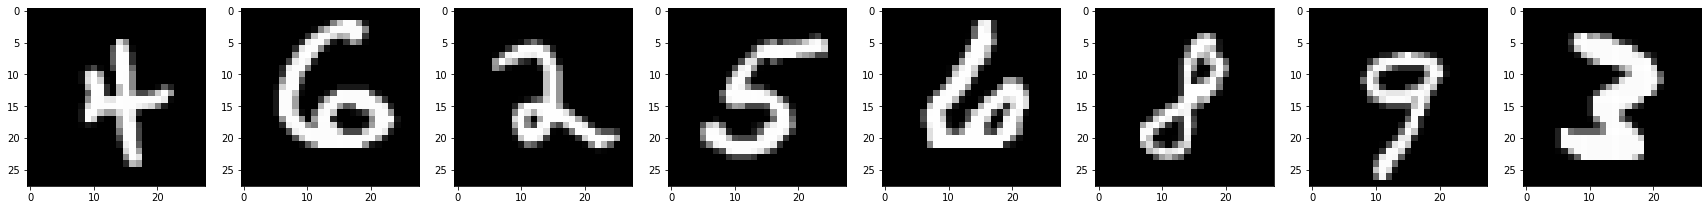

In [8]:
# Plot eight random digits in the training data set
plt.figure(figsize=(30,20))
for i in range(1,9):
    j=random.randint(0, 42000)
    plt.subplot(1,8,i)
    grid_data = mnist_train.iloc[j,1:785].values.reshape(28,28)
    plt.imshow(grid_data, interpolation = 'none', cmap = 'gray')
plt.show()


<AxesSubplot:xlabel='label', ylabel='count'>

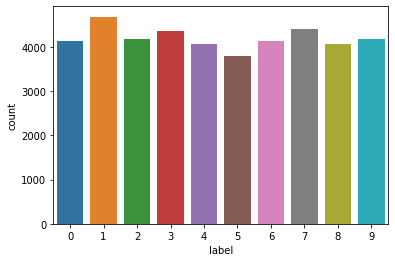

In [9]:
# count plots for the labels - training data set
sns.countplot(x = "label", data = mnist_train)

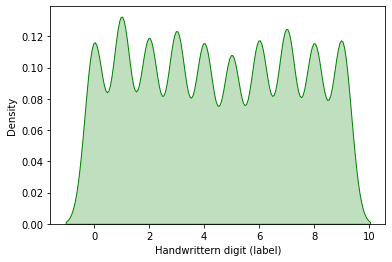

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
# create a kernel density plot
# KDE plot  
sns.kdeplot(mnist_train["label"], color = "green",  
            shade = True) 
plt.xlabel("Handwrittern digit (label)", fontsize=10)
plt.show() 
plt.figure() 

/Users/harini-mac/Desktop/Northwestern University/MSDS-422/my_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


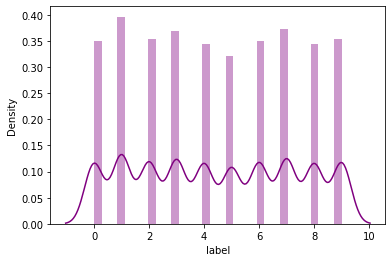

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
# Histogram+Density Plot  
sns.distplot(mnist_train["label"], color = "purple") 
plt.show() 
plt.figure()

# Data Normalization and Preparation

In [12]:
# Prepare X_train_unscaled, y_train, and X_test_unscaled
# Note we do not have y_test
X_train_full = mnist_train.iloc[:,1:785]
y_train_full = mnist_train['label']
X_test_full = mnist_test

In [13]:
# Normalize the data 
X_train = X_train_full / 255.0
X_test = X_test_full / 255.0

In [14]:
#Reshape the data for model training
X_train = X_train.values.reshape(X_train.shape[0], 28, 28).astype('float32')

In [15]:
X_train.shape

(42000, 28, 28)

In [16]:
#Reshape the data for prediction
X_test = X_test.values.reshape(X_test.shape[0], 28, 28).astype('float32')

In [17]:
X_test.shape

(28000, 28, 28)

# Setup a stacked autoencoder

In [18]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(512, activation="selu"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(64, activation="selu", input_shape=(30,)),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation="selu"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [19]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5))

In [20]:
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 30)                576350    
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            577104    
Total params: 1,153,454
Trainable params: 1,153,454
Non-trainable params: 0
_________________________________________________________________


# Fit the stacked autoencoder model

In [21]:
history = stacked_ae.fit(X_train, X_train, batch_size=32, epochs=100, validation_split=0.3)


Epoch 1/100
919/919 [==============================] - 7s 7ms/step - loss: 0.2844 - val_loss: 0.2416
Epoch 2/100
919/919 [==============================] - 7s 7ms/step - loss: 0.2482 - val_loss: 0.2301
Epoch 3/100
919/919 [==============================] - 7s 7ms/step - loss: 0.2380 - val_loss: 0.2231
Epoch 4/100
919/919 [==============================] - 7s 8ms/step - loss: 0.2328 - val_loss: 0.2182
Epoch 5/100
919/919 [==============================] - 8s 9ms/step - loss: 0.2289 - val_loss: 0.2134
Epoch 6/100
919/919 [==============================] - 8s 9ms/step - loss: 0.2250 - val_loss: 0.2081
Epoch 7/100
919/919 [==============================] - 8s 9ms/step - loss: 0.2216 - val_loss: 0.2049
Epoch 8/100
919/919 [==============================] - 9s 10ms/step - loss: 0.2186 - val_loss: 0.2016
Epoch 9/100
919/919 [==============================] - 9s 10ms/step - loss: 0.2163 - val_loss: 0.1985
Epoch 10/100
919/919 [==============================] - 10s 10ms/step - loss: 0.2130 - va

919/919 [==============================] - 12s 13ms/step - loss: 0.1842 - val_loss: 0.1628
Epoch 81/100
919/919 [==============================] - 12s 13ms/step - loss: 0.1839 - val_loss: 0.1619
Epoch 82/100
919/919 [==============================] - 12s 13ms/step - loss: 0.1840 - val_loss: 0.1624
Epoch 83/100
919/919 [==============================] - 12s 13ms/step - loss: 0.1839 - val_loss: 0.1623
Epoch 84/100
919/919 [==============================] - 12s 13ms/step - loss: 0.1837 - val_loss: 0.1621
Epoch 85/100
919/919 [==============================] - 12s 13ms/step - loss: 0.1838 - val_loss: 0.1624
Epoch 86/100
919/919 [==============================] - 12s 13ms/step - loss: 0.1838 - val_loss: 0.1625
Epoch 87/100
919/919 [==============================] - 12s 13ms/step - loss: 0.1836 - val_loss: 0.1618
Epoch 88/100
919/919 [==============================] - 12s 13ms/step - loss: 0.1835 - val_loss: 0.1618
Epoch 89/100
919/919 [==============================] - 12s 13ms/step - loss:

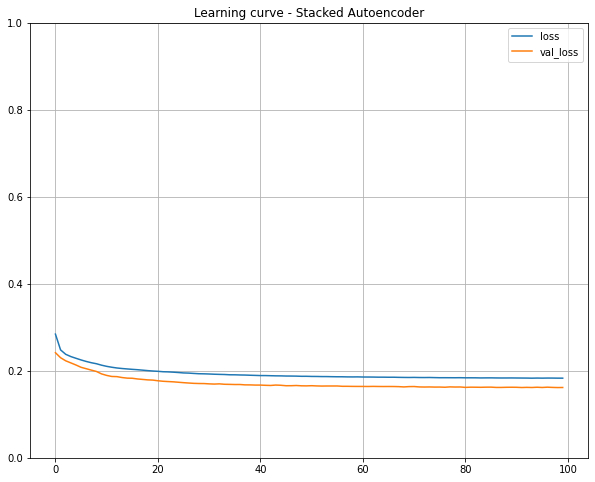

In [22]:
# Plot the learning curve
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - Stacked Autoencoder')
plt.show()

# Display original images and reconstructions obtained using stacked autoencoder

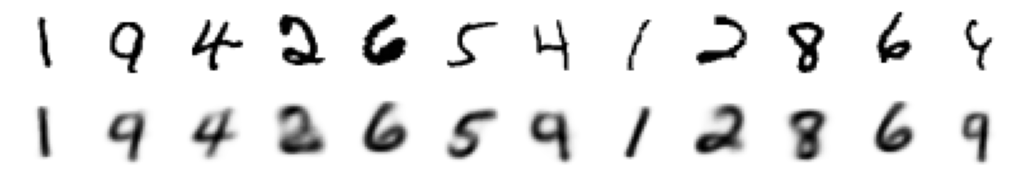

In [23]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images):
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        randno = random.randint(0, 42000)
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_train[randno])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(model.predict(X_train[randno].reshape(-1,28,28))[0])

show_reconstructions(stacked_ae, 12)

# Visualize the dimension reduction (encoder output) using t-SNE

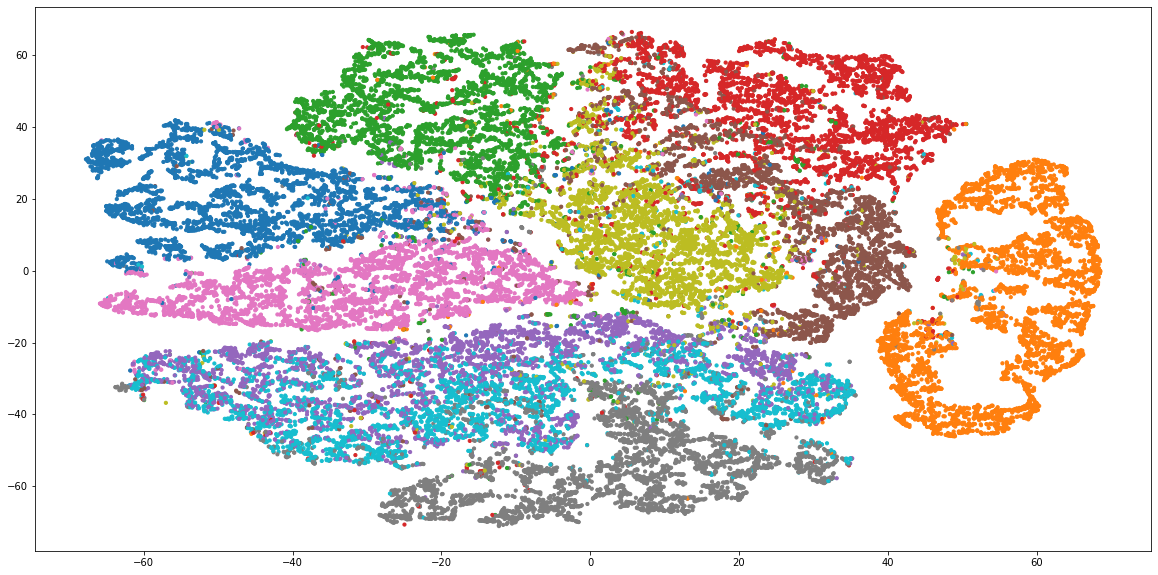

In [24]:
from sklearn.manifold import TSNE
plt.figure(figsize=(20,10))
X_train_compressed = stacked_encoder.predict(X_train)
tsne = TSNE()
X_train_2D = tsne.fit_transform(X_train_compressed)
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=y_train_full, s=10, cmap="tab10")

# Build a classifier using the stacked autoencoder data

In [25]:
#classification MLP 
classifier_model = keras.models.Sequential()
classifier_model.add(keras.layers.Flatten(input_shape=[30]))
classifier_model.add(keras.layers.Dense(30, activation="relu"))
classifier_model.add(keras.layers.Dense(10, activation="softmax"))

classifier_model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [26]:
classifier_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                310       
Total params: 1,240
Trainable params: 1,240
Non-trainable params: 0
_________________________________________________________________


In [27]:
classifier_model.layers

In [28]:
history_classifier = classifier_model.fit(X_train_compressed, y_train_full.ravel(), epochs=100,validation_split=0.3)

Epoch 1/100
919/919 [==============================] - 1s 787us/step - loss: 0.7399 - accuracy: 0.7707 - val_loss: 0.4805 - val_accuracy: 0.8420
Epoch 2/100
919/919 [==============================] - 1s 757us/step - loss: 0.4517 - accuracy: 0.8466 - val_loss: 0.4360 - val_accuracy: 0.8529
Epoch 3/100
919/919 [==============================] - 1s 749us/step - loss: 0.4199 - accuracy: 0.8538 - val_loss: 0.4081 - val_accuracy: 0.8599
Epoch 4/100
919/919 [==============================] - 1s 688us/step - loss: 0.4024 - accuracy: 0.8599 - val_loss: 0.3954 - val_accuracy: 0.8637
Epoch 5/100
919/919 [==============================] - 1s 710us/step - loss: 0.3900 - accuracy: 0.8618 - val_loss: 0.3841 - val_accuracy: 0.8679
Epoch 6/100
919/919 [==============================] - 1s 707us/step - loss: 0.3815 - accuracy: 0.8645 - val_loss: 0.3767 - val_accuracy: 0.8691
Epoch 7/100
919/919 [==============================] - 1s 701us/step - loss: 0.3741 - accuracy: 0.8671 - val_loss: 0.3685 - val_ac

In [29]:
print ('Train Accuracy: ')
best_model_train_accuracy = np.round(history_classifier.history['accuracy'][np.argmin(history_classifier.history['loss'])],4)
best_model_train_accuracy

Train Accuracy: 


0.8936

In [30]:
print ('Validation Accuracy: ')
best_model_val_accuracy = np.round(history_classifier.history['val_accuracy'][np.argmin(history_classifier.history['val_loss'])],4)
best_model_val_accuracy

Validation Accuracy: 


0.8897

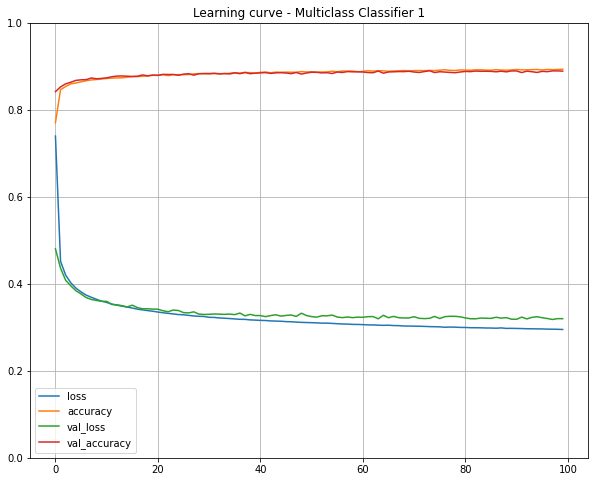

In [31]:
# Plot the learning curve
pd.DataFrame(history_classifier.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - Multiclass Classifier 1')
plt.show()

# Obtain the predictions for MNIST test data

In [32]:
# obtain the predictions for X_test 
X_test_compressed = stacked_encoder.predict(X_test)
test_pred = np.argmax(classifier_model.predict(X_test_compressed), axis=-1)
test_pred

array([2, 0, 9, ..., 3, 9, 2])

In [33]:
# save the results to a csv
submission_df = pd.DataFrame({'ImageId':range(1,28001),'Label':test_pred})
submission_df.to_csv('submission_model_autoencoder_classifier.csv',index=False)

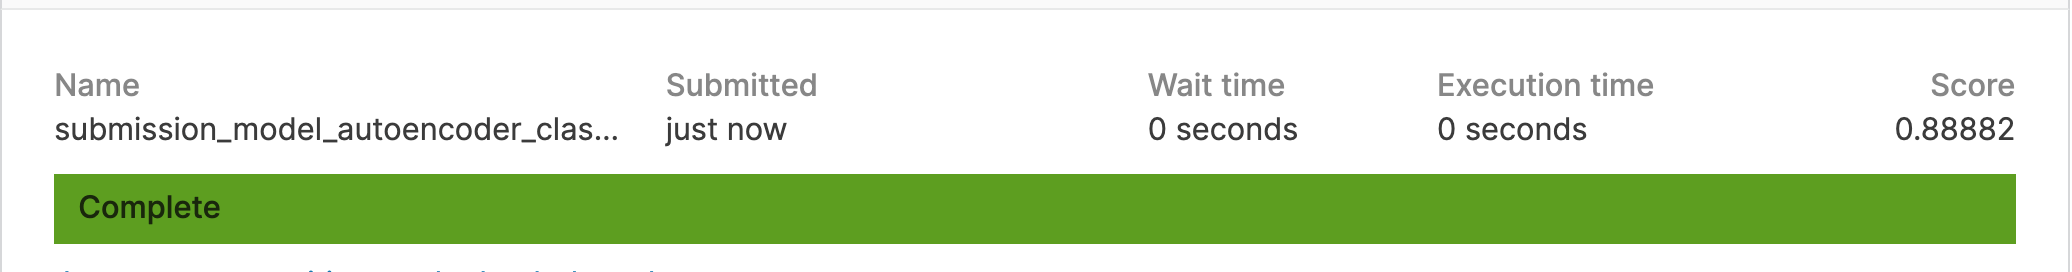

# Setup a convolutional autoencoder

In [34]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",
                                 activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",
                                 activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [35]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5))

In [36]:
conv_ae.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 3, 3, 64)          23296     
_________________________________________________________________
sequential_5 (Sequential)    (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


# Fit the convolutional autoencoder model

In [37]:
history_conv = conv_ae.fit(X_train, X_train, batch_size=32, epochs=100, validation_split=0.3)

Epoch 1/100
919/919 [==============================] - 28s 30ms/step - loss: 0.1196 - val_loss: 0.0905
Epoch 2/100
919/919 [==============================] - 28s 31ms/step - loss: 0.0859 - val_loss: 0.0807
Epoch 3/100
919/919 [==============================] - 28s 31ms/step - loss: 0.0805 - val_loss: 0.0780
Epoch 4/100
919/919 [==============================] - 26s 28ms/step - loss: 0.0778 - val_loss: 0.0765
Epoch 5/100
919/919 [==============================] - 25s 27ms/step - loss: 0.0762 - val_loss: 0.0747
Epoch 6/100
919/919 [==============================] - 26s 28ms/step - loss: 0.0750 - val_loss: 0.0742
Epoch 7/100
919/919 [==============================] - 27s 30ms/step - loss: 0.0741 - val_loss: 0.0739
Epoch 8/100
919/919 [==============================] - 28s 30ms/step - loss: 0.0734 - val_loss: 0.0725
Epoch 9/100
919/919 [==============================] - 27s 29ms/step - loss: 0.0728 - val_loss: 0.0723
Epoch 10/100
919/919 [==============================] - 26s 28ms/step - l

Epoch 80/100
919/919 [==============================] - 28s 30ms/step - loss: 0.0665 - val_loss: 0.0667
Epoch 81/100
919/919 [==============================] - 28s 31ms/step - loss: 0.0665 - val_loss: 0.0663
Epoch 82/100
919/919 [==============================] - 26s 28ms/step - loss: 0.0665 - val_loss: 0.0666
Epoch 83/100
919/919 [==============================] - 26s 28ms/step - loss: 0.0665 - val_loss: 0.0665
Epoch 84/100
919/919 [==============================] - 27s 29ms/step - loss: 0.0664 - val_loss: 0.0662
Epoch 85/100
919/919 [==============================] - 29s 31ms/step - loss: 0.0664 - val_loss: 0.0665
Epoch 86/100
919/919 [==============================] - 28s 30ms/step - loss: 0.0664 - val_loss: 0.0666
Epoch 87/100
919/919 [==============================] - 26s 28ms/step - loss: 0.0664 - val_loss: 0.0669
Epoch 88/100
919/919 [==============================] - 27s 29ms/step - loss: 0.0664 - val_loss: 0.0662
Epoch 89/100
919/919 [==============================] - 27s 30ms

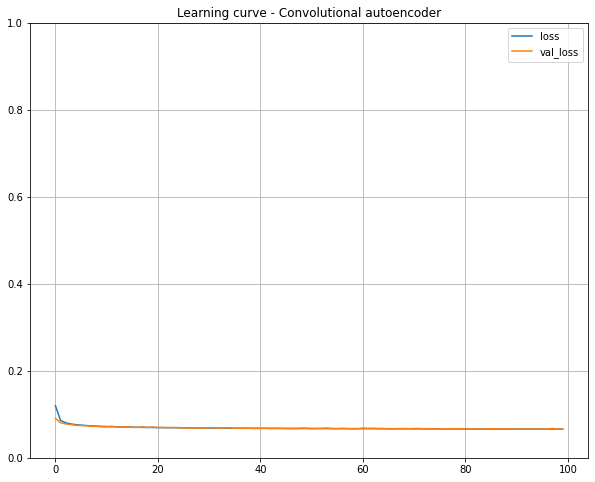

In [38]:
# Plot the learning curve
pd.DataFrame(history_conv.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - Convolutional autoencoder')
plt.show()

# Display original images and reconstructions

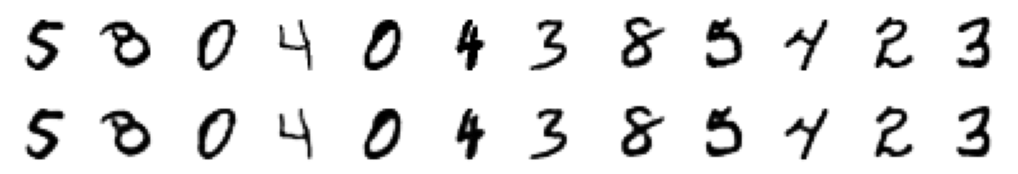

In [39]:
show_reconstructions(conv_ae, 12)

# Build a classifier using the representations from convolutional autoencoder

In [40]:
X_train_conv_compressed = conv_encoder.predict(X_train)

In [41]:
from tensorflow import keras
#classification MLP 
classifier_model = keras.models.Sequential()
classifier_model.add(keras.layers.Flatten(input_shape=[3,3,64]))
classifier_model.add(keras.layers.Dense(30, activation="relu"))
classifier_model.add(keras.layers.Dense(10, activation="softmax"))

classifier_model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [42]:
classifier_model.layers

In [43]:
history_classifier_2 = classifier_model.fit(X_train_conv_compressed, y_train_full.ravel(), epochs=100,validation_split=0.3)

Epoch 1/100
919/919 [==============================] - 1s 991us/step - loss: 0.7420 - accuracy: 0.7619 - val_loss: 0.4276 - val_accuracy: 0.8656
Epoch 2/100
919/919 [==============================] - 1s 881us/step - loss: 0.2821 - accuracy: 0.9141 - val_loss: 0.3077 - val_accuracy: 0.9063
Epoch 3/100
919/919 [==============================] - 1s 807us/step - loss: 0.2228 - accuracy: 0.9317 - val_loss: 0.1942 - val_accuracy: 0.9402
Epoch 4/100
919/919 [==============================] - 1s 884us/step - loss: 0.1950 - accuracy: 0.9393 - val_loss: 0.1822 - val_accuracy: 0.9456
Epoch 5/100
919/919 [==============================] - 1s 763us/step - loss: 0.1771 - accuracy: 0.9440 - val_loss: 0.1689 - val_accuracy: 0.9454
Epoch 6/100
919/919 [==============================] - 1s 795us/step - loss: 0.1594 - accuracy: 0.9504 - val_loss: 0.2145 - val_accuracy: 0.9293
Epoch 7/100
919/919 [==============================] - 1s 747us/step - loss: 0.1520 - accuracy: 0.9527 - val_loss: 0.1775 - val_ac

In [44]:
print ('Train Accuracy: ')
best_model_train_accuracy = np.round(history_classifier_2.history['accuracy'][np.argmin(history_classifier_2.history['loss'])],4)
best_model_train_accuracy

Train Accuracy: 


0.9878

In [45]:
print ('Validation Accuracy: ')
best_model_val_accuracy = np.round(history_classifier_2.history['val_accuracy'][np.argmin(history_classifier_2.history['val_loss'])],4)
best_model_val_accuracy

Validation Accuracy: 


0.9764

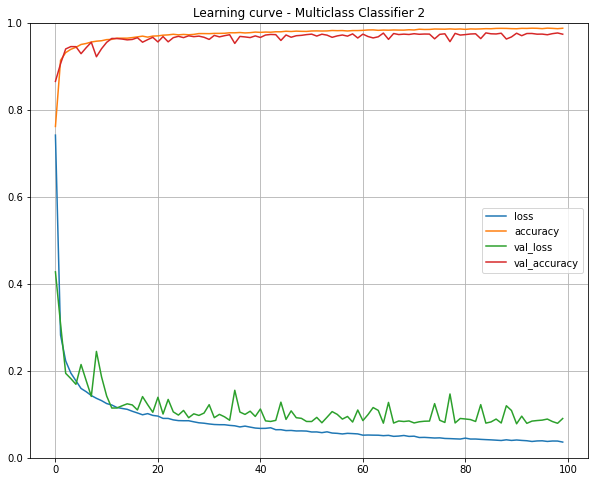

In [46]:
# Plot the learning curve
pd.DataFrame(history_classifier_2.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - Multiclass Classifier 2')
plt.show()

In [47]:
# obtain the predictions for X_test 
X_test_conv_compressed = conv_encoder.predict(X_test)
test_pred_conv = np.argmax(classifier_model.predict(X_test_conv_compressed), axis=-1)
test_pred_conv

array([2, 0, 9, ..., 3, 9, 2])

In [48]:
# save the results to a csv
submission_df = pd.DataFrame({'ImageId':range(1,28001),'Label':test_pred_conv})
submission_df.to_csv('submission_model_conv_autoencoder_classifier.csv',index=False)

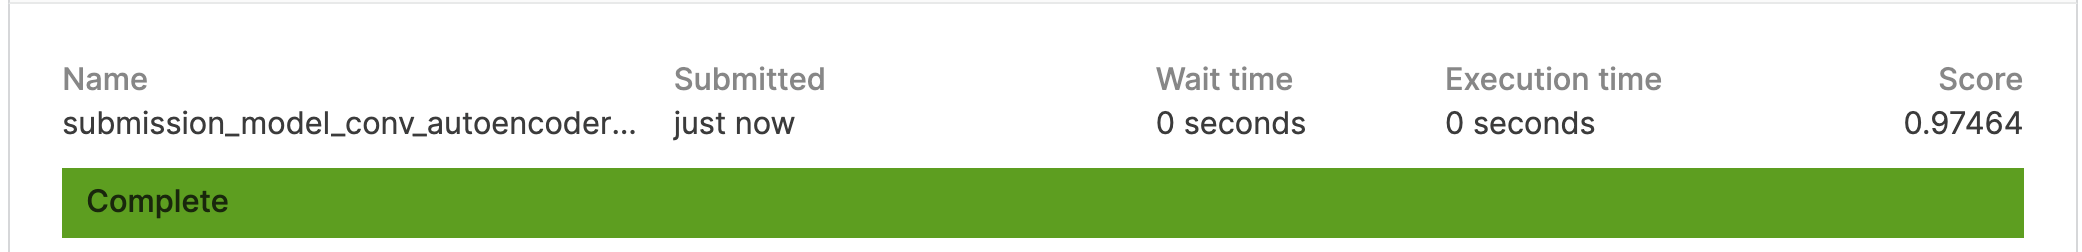

# Setup a variational autoencoder

In [49]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.keras.backend.random_normal(tf.shape(log_var)) * tf.keras.backend.exp(log_var / 2) + mean

In [50]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)  # μ
codings_log_var = keras.layers.Dense(codings_size)(z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [51]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [52]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [53]:
latent_loss = -0.5 * tf.keras.backend.sum(
    1 + codings_log_var -tf.keras.backend.exp(codings_log_var) - tf.keras.backend.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.keras.backend.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [54]:
history_variational = variational_ae.fit(X_train, X_train, epochs=100, batch_size=32,
                             validation_split=0.3)

Epoch 1/100
919/919 [==============================] - 3s 3ms/step - loss: 0.2061 - val_loss: 0.1763
Epoch 2/100
919/919 [==============================] - 3s 3ms/step - loss: 0.1688 - val_loss: 0.1665
Epoch 3/100
919/919 [==============================] - 3s 3ms/step - loss: 0.1606 - val_loss: 0.1587
Epoch 4/100
919/919 [==============================] - 3s 3ms/step - loss: 0.1564 - val_loss: 0.1543
Epoch 5/100
919/919 [==============================] - 3s 4ms/step - loss: 0.1537 - val_loss: 0.1535
Epoch 6/100
919/919 [==============================] - 3s 3ms/step - loss: 0.1518 - val_loss: 0.1503
Epoch 7/100
919/919 [==============================] - 5s 5ms/step - loss: 0.1504 - val_loss: 0.1516
Epoch 8/100
919/919 [==============================] - 3s 3ms/step - loss: 0.1491 - val_loss: 0.1489
Epoch 9/100
919/919 [==============================] - 3s 3ms/step - loss: 0.1482 - val_loss: 0.1473
Epoch 10/100
919/919 [==============================] - 3s 3ms/step - loss: 0.1474 - val_lo

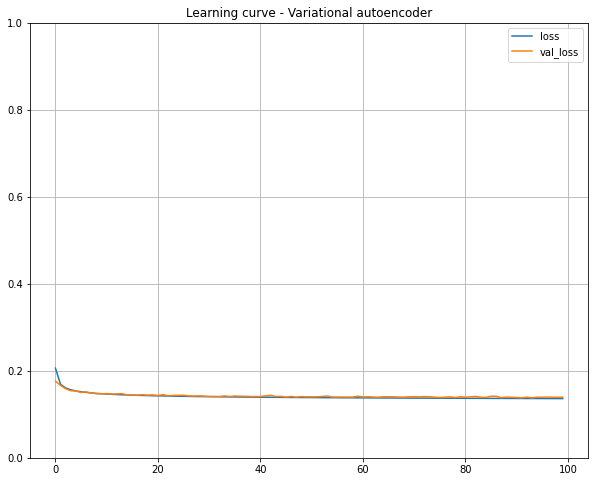

In [55]:
# Plot the learning curve
pd.DataFrame(history_variational.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - Variational autoencoder')
plt.show()

# Display original images and reconstructions

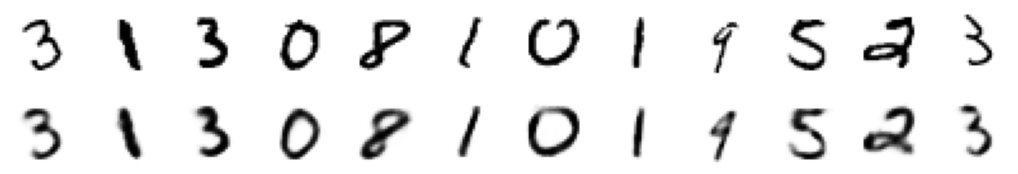

In [56]:
show_reconstructions(variational_ae, 12)

# Build a classifier using the representations from variational autoencoder

In [57]:
_, _, X_train_var_compressed = variational_encoder.predict(X_train)

In [58]:
from tensorflow import keras
#classification MLP 
classifier_model = keras.models.Sequential()
classifier_model.add(keras.layers.Flatten(input_shape=[10]))
classifier_model.add(keras.layers.Dense(30, activation="relu"))
classifier_model.add(keras.layers.Dense(10, activation="softmax"))

classifier_model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [59]:
classifier_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 30)                330       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                310       
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


In [60]:
classifier_model.layers

In [61]:
history_classifier_3 = classifier_model.fit(X_train_var_compressed, y_train_full.ravel(), epochs=100,validation_split=0.3)

Epoch 1/100
919/919 [==============================] - 1s 732us/step - loss: 1.4784 - accuracy: 0.5646 - val_loss: 0.8302 - val_accuracy: 0.8018
Epoch 2/100
919/919 [==============================] - 1s 678us/step - loss: 0.6218 - accuracy: 0.8423 - val_loss: 0.5043 - val_accuracy: 0.8641
Epoch 3/100
919/919 [==============================] - 1s 632us/step - loss: 0.4497 - accuracy: 0.8724 - val_loss: 0.4171 - val_accuracy: 0.8802
Epoch 4/100
919/919 [==============================] - 1s 685us/step - loss: 0.3904 - accuracy: 0.8854 - val_loss: 0.3778 - val_accuracy: 0.8879
Epoch 5/100
919/919 [==============================] - 1s 691us/step - loss: 0.3593 - accuracy: 0.8919 - val_loss: 0.3539 - val_accuracy: 0.8935
Epoch 6/100
919/919 [==============================] - 1s 673us/step - loss: 0.3387 - accuracy: 0.8978 - val_loss: 0.3377 - val_accuracy: 0.8957
Epoch 7/100
919/919 [==============================] - 1s 682us/step - loss: 0.3235 - accuracy: 0.9011 - val_loss: 0.3240 - val_ac

In [62]:
print ('Train Accuracy: ')
best_model_train_accuracy = np.round(history_classifier_3.history['accuracy'][np.argmin(history_classifier_3.history['loss'])],4)
best_model_train_accuracy

Train Accuracy: 


0.9488

In [63]:
print ('Validation Accuracy: ')
best_model_val_accuracy = np.round(history_classifier_3.history['val_accuracy'][np.argmin(history_classifier_3.history['val_loss'])],4)
best_model_val_accuracy

Validation Accuracy: 


0.939

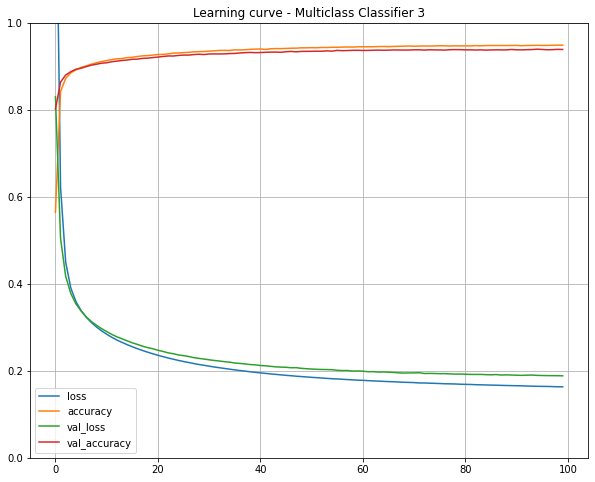

In [64]:
# Plot the learning curve
pd.DataFrame(history_classifier_3.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - Multiclass Classifier 3')
plt.show()

# Obtain the predictions for X_test

In [65]:
# obtain the predictions for X_test 
_, _, X_test_var_compressed = variational_encoder.predict(X_test)
test_pred_var = np.argmax(classifier_model.predict(X_test_var_compressed), axis=-1)
test_pred_var

array([2, 0, 9, ..., 3, 9, 2])

In [66]:
# save the results to a csv
submission_df = pd.DataFrame({'ImageId':range(1,28001),'Label':test_pred_var})
submission_df.to_csv('submission_model_var_autoencoder_classifier.csv',index=False)

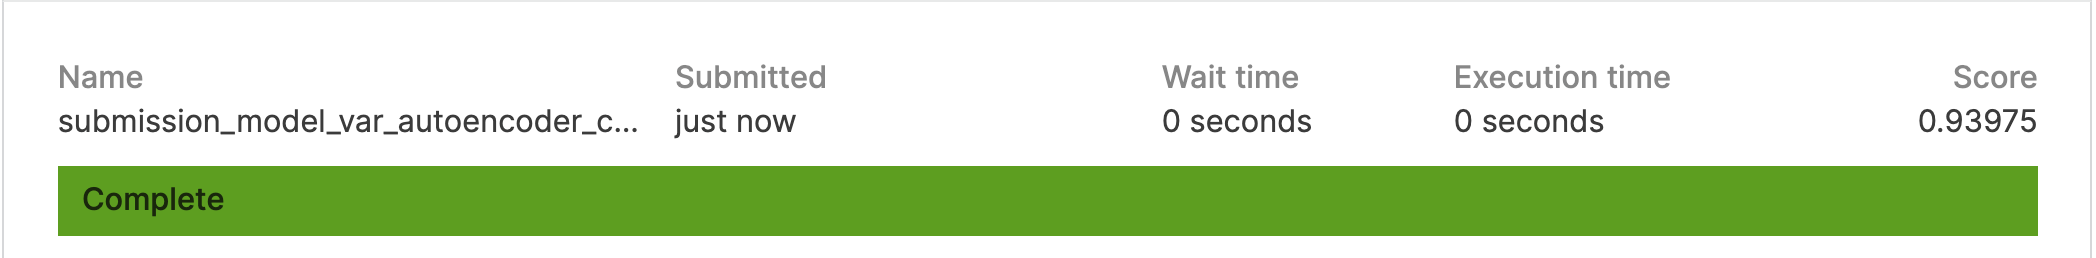